In [1]:
# ====== import commonly used libraries ====== #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from scipy.cluster.hierarchy import linkage, dendrogram
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ====== Import dataset and display unique genotypes ====== #
bloodtype_df = pd.read_csv("bloodtype_unprocessed.csv")
print("Unique values per SNP:")
snp_columns = [col for col in bloodtype_df.columns if col.startswith('rs') or col.startswith('i')]
for rsid in snp_columns:
    print(rsid, bloodtype_df[rsid].unique())

Unique values per SNP:
rs8176719 ['DI' 'DD' 'NN' 'II' '--' '-C' 'AA' 'TT']
rs505922 ['CT' 'TT' 'NN' 'CC' 'TC' '--' 'AA' 'D']
rs657152 ['AC' 'CC' 'NN' 'AA' 'GG' 'CA' '0' '--' 'TT' 'CT']
rs8176704 ['GG' 'AG' 'NN' 'AA' '--' 'CC' 'GA' '0' 'AC']
rs612169 ['NN' 'AA' 'AG' 'GG']
rs529565 ['NN' 'TT' 'CC' 'TC' 'CT']
rs8176693 ['CC' 'NN' 'CT' 'TC' '0' 'T' 'TT' 'GG' '--']
rs514659 ['AC' 'NN' 'AA' '--' 'CC' 'CA']
rs8176645 ['NN' 'TA' 'TT' 'AA' 'AT' 'C']
rs512770 ['NN' 'AG' 'GG' 'AA' '0' '--' 'AC']
rs688976 ['NN' 'AC' 'CC' 'AA' '0' '--' 'GG']
rs8176672 ['NN' 'CC' 'AG']
rs8176741 ['NN' 'GG' 'AG' '--' 'AA' 'CC' 'GA' '0' 'A' 'AC']
rs8176722 ['CC' 'AC' 'NN' 'AA' 'CA' 'A' '--' 'GG' '0']
rs8176720 ['NN' 'CT' 'CC' 'TT' 'AA' 'TC' 'T' '--' '0' 'GG']
rs7853989 ['NN' 'GG' 'CG' '--' 'GC' 'CC' 'TT' '0' 'G']
rs8176743 ['NN' 'CC' 'CT' 'TC' 'TT' '--' '0' 'GG']
rs8176747 ['NN' 'CC' 'CG' '--' 'GG' '0' 'C']
rs635634 ['CT' 'NN' 'CC' 'GG' 'TC' 'TT' 'C']
rs507666 ['AG' 'GG' 'NN' 'AA' 'CC' 'GA' '--' 'T']
rs687289 ['AG' 'N

In [3]:
# ====== Pre-process the data using DataProcessor ====== #
from data_processor import DataProcessor

# Initialize data processor
data_processor = DataProcessor("bloodtype_unprocessed.csv", "bloodtype_snps.csv")

# Run full pipeline
data_processor.load_data()
data_processor.remove_duplicates()
data_processor.define_snp_columns()
data_processor.standardize_phenotype(trait_col='blood_type', new_col='Blood_type_standardized')
data_processor.standardize_genotypes()
data_processor.clean_columns(cutoff=3)
data_processor.save_cleaned()

Sample size: 868
Columns: ['user_num', 'ID-number', 'blood_type', 'rs8176719', 'rs505922', 'rs657152', 'rs8176704', 'rs612169', 'rs529565', 'rs8176693', 'rs514659', 'rs8176645', 'rs512770', 'rs688976', 'rs8176672', 'rs8176741', 'rs8176722', 'rs8176720', 'rs7853989', 'rs8176743', 'rs8176747', 'rs635634', 'rs507666', 'rs687289', 'rs8176746 ', 'rs8176749', 'rs7030248', 'rs590787', 'i4001527', 'rs41302905']
Sample size after removing duplicates: 867
SNP columns: ['rs8176719', 'rs505922', 'rs657152', 'rs8176704', 'rs612169', 'rs529565', 'rs8176693', 'rs514659', 'rs8176645', 'rs512770', 'rs688976', 'rs8176672', 'rs8176741', 'rs8176722', 'rs8176720', 'rs7853989', 'rs8176743', 'rs8176747', 'rs635634', 'rs507666', 'rs687289', 'rs8176746 ', 'rs8176749', 'rs7030248', 'rs590787', 'i4001527', 'rs41302905']
Standardized blood_type values written to 'Blood_type_standardized'.
Genotypes standardized.
Unique values per SNP (showing up to 10):
rs8176719: ['DI' 'DD' 'NN' 'II']
rs505922: ['CT' 'TT' 'NN' '

In [4]:
# ====== Remove rows where both 'rs8176719' and 'rs505922' are missing ('NN') ====== #
def remove_missing_rows(bloodtype_df):
    print(f'Number of rows before filtering: {len(bloodtype_df)}')
    # Keep rows where at least one of the two SNPs is not 'NN'
    bloodtype_df = bloodtype_df[~((bloodtype_df['rs8176719'] == 'NN') & (bloodtype_df['rs505922'] == 'NN'))]
    print(f'Number of rows after filtering: {len(bloodtype_df)}')
    # Save to CSV
    bloodtype_df.to_csv('bloodtype_processed.csv', index=False)
    return bloodtype_df

# Load the dataset and remove missing rows
bloodtype_cleaned = pd.read_csv('bloodtype_cleaned.csv')
rs_columns = [col for col in bloodtype_cleaned.columns if col.startswith('rs') or col.startswith('i')]  # SNP columns

bloodtype_cleaned = remove_missing_rows(bloodtype_cleaned)

for rs in rs_columns:
    print(rs, bloodtype_cleaned[rs].unique())

Number of rows before filtering: 867
Number of rows after filtering: 732
rs8176719 ['DI' 'DD' 'II' 'NN']
rs505922 ['CT' 'TT' 'CC' 'NN' 'DD']
rs657152 ['AC' 'CC' 'AA' 'NN']
rs8176704 ['GG' 'AG' 'NN' 'AA']
rs512770 ['NN' 'AG' 'GG' 'AA']
rs8176722 ['CC' 'AC' 'NN' 'AA']
rs8176720 ['NN' 'CT' 'CC' 'TT']
rs7853989 ['NN' 'GG' 'CG' 'CC' 'AA']
rs8176743 ['NN' 'CC' 'CT' 'TT']
rs507666 ['AG' 'GG' 'NN' 'AA']
rs8176749 ['NN' 'CC' 'CT' 'TT']
rs7030248 ['GG' 'AG' 'NN' 'AA']
rs41302905 ['NN' 'CC' 'CT']


In [5]:
# ======= Remove rows with invalid genotype ======= #
invalid_rows_rs505922 = bloodtype_cleaned[bloodtype_cleaned['rs505922'] == 'DD']
invalid_rows_rs7853989 = bloodtype_cleaned[bloodtype_cleaned['rs7853989'] == 'AA'] 

invalid_rows = {'rs505922': invalid_rows_rs505922,
                'rs7853989': invalid_rows_rs7853989}

for rs, row in invalid_rows.items():
    if not row.empty:
        print(f"User(s) with invalid value for {rs}:")
        print(len(row['ID-number'].tolist()))
    else:
        print("No users with invalid values found.")

bloodtype_cleaned = bloodtype_cleaned[bloodtype_cleaned['rs505922'] != 'DD']
bloodtype_cleaned = bloodtype_cleaned[bloodtype_cleaned['rs7853989'] != 'AA']

rs_columns = [col for col in bloodtype_cleaned.columns if col.startswith('rs') or col.startswith('i')]  # SNP columns

for rs in rs_columns:
    print(rs, bloodtype_cleaned[rs].unique())

User(s) with invalid value for rs505922:
1
User(s) with invalid value for rs7853989:
1
rs8176719 ['DI' 'DD' 'II' 'NN']
rs505922 ['CT' 'TT' 'CC' 'NN']
rs657152 ['AC' 'CC' 'AA' 'NN']
rs8176704 ['GG' 'AG' 'NN' 'AA']
rs512770 ['NN' 'AG' 'GG' 'AA']
rs8176722 ['CC' 'AC' 'NN' 'AA']
rs8176720 ['NN' 'CT' 'CC' 'TT']
rs7853989 ['NN' 'GG' 'CG' 'CC']
rs8176743 ['NN' 'CC' 'CT' 'TT']
rs507666 ['AG' 'GG' 'NN' 'AA']
rs8176749 ['NN' 'CC' 'CT' 'TT']
rs7030248 ['GG' 'AG' 'NN' 'AA']
rs41302905 ['NN' 'CC' 'CT']


In [6]:
# ============ Standardization and Grouping ============ #
# Import genotype processor
from genotype_processor import GenotypeProcessor

# Load data and SNP info
bloodtype_cleaned = pd.read_csv("bloodtype_cleaned.csv")
snp_cols = [col for col in bloodtype_cleaned.columns if col.startswith('rs') or col.startswith('i')]

# Set up processor
genotype_processor = GenotypeProcessor(bloodtype_cleaned,
                                       'blood_type',
                                       snp_cols=snp_cols)

# Print unique blood types based on "blood_type" col.
genotype_processor.print_unique_traits('blood_type')

Unique blood_type: ['A+' 'B+' 'B-' 'O-' 'O+' 'A-' 'AB+' 'b+' 'O +' 'Ab+' 'AB-' 'O' 'Ab-' '0+'
 'No' 'O/o +/-' 'B'],


In [7]:
# Remove rows with invalid type reported
print(f'Number of rows before filtering: {len(bloodtype_cleaned)}')
bloodtype_cleaned = bloodtype_cleaned[
    (bloodtype_cleaned['blood_type'] != 'No') & (bloodtype_cleaned['blood_type'] != 'O/o +/-')]
print(f'Number of rows after filtering: {len(bloodtype_cleaned)}')

# defines map for type standardization
types_mapping = {
    'A': ['A+', 'A-'],
    'B': ['B+', 'b+', 'B', 'B-'],
    'AB': ['AB+', 'Ab+', 'AB-', 'Ab-'],
    'O': ['O+', 'O', '0+', 'O +', 'O-']}

# Standardize types
bloodtype_std = genotype_processor.standardize_traits(types_mapping, 'blood_type',
                                                      'Bloodtype Standardized', bloodtype_cleaned)
bloodtype_std.to_csv('bloodtype_standardized.csv', index=False)

# Print unique types after standardization
genotype_processor.print_unique_traits('Bloodtype Standardized', bloodtype_std)

Number of rows before filtering: 867
Number of rows after filtering: 862
Unique Bloodtype Standardized: ['A' 'B' 'O' 'AB'],


In [8]:
# ===== Encode SNPs and plot PCA and MDS ===== #
# Load standardized data and SNP info
bloodtype_standardized = pd.read_csv("bloodtype_standardized.csv")
snp_info = pd.read_csv("bloodtype_snps.csv").set_index('rsid')
snp_cols = [col for col in bloodtype_standardized.columns if col.startswith('rs') or col.startswith('i')]

# Set up processor
genotype_processor = GenotypeProcessor(bloodtype_standardized,
                                       'Bloodtype Standardized',
                                       snp_cols=snp_cols)

# Filter by minimum samples and impute missing genotypes
genotype_processor.filter_by_min_samples(5).impute_missing_genotypes('NN')

# Encode SNPs
bloodtype_encoded = genotype_processor.encode_snps(snp_info, effect_dosage=1, other_dosage=-1, missing_value=0)
bloodtype_encoded.head(5)


--- Trait Counts (Bottom 10, After Filtering) ---
Bloodtype Standardized
O     353
A     346
B     107
AB     56
Name: count, dtype: int64
-----------------------
Number of traits before filtering: 4
Number of traits after filtering:  4



,Bloodtype Standardized,rs8176719,rs505922,rs657152,rs8176704,rs512770,rs8176722,rs8176720,rs7853989,rs8176743,rs507666,rs8176749,rs7030248,rs41302905
0,A,0,0,0,2,2,2,2,-2,2,0,2,-2,-2
1,A,0,0,0,2,0,2,0,-2,2,0,2,-2,-2
2,B,0,0,0,2,0,0,-2,0,0,-2,0,0,-2
3,B,0,0,0,2,2,0,0,0,0,-2,0,-2,-2
4,B,0,0,0,2,0,0,0,0,0,-2,0,0,-2


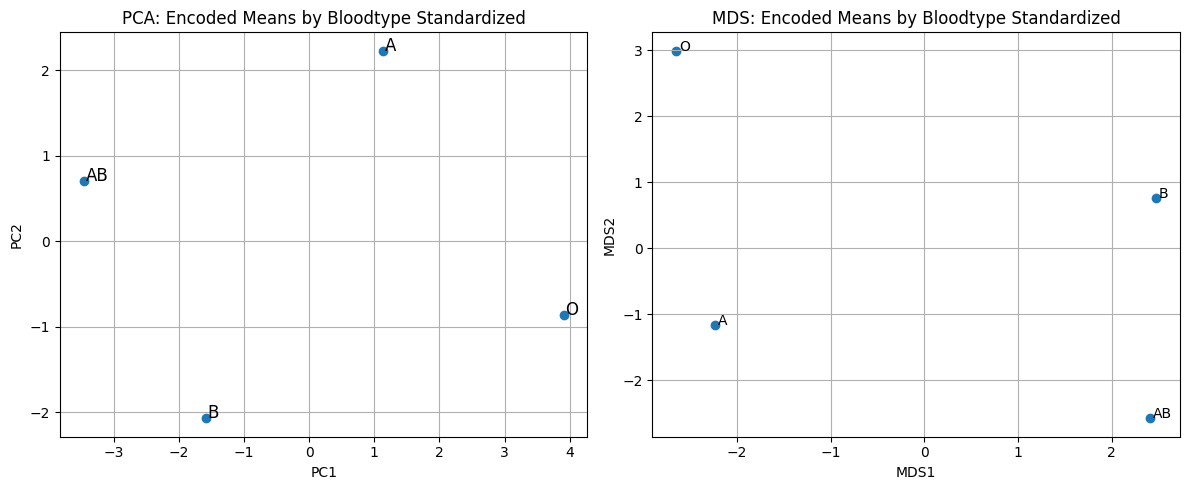

In [9]:
# Plot PCA and MDS
genotype_processor.plot_pca_mds(bloodtype_encoded, 'Bloodtype Standardized', figsize=(12, 5), annotate=True)


=== Class Distribution (Original) ===
A                    Count:  346   Frequency: 0.401
AB                   Count:   56   Frequency: 0.065
B                    Count:  107   Frequency: 0.124
O                    Count:  353   Frequency: 0.410

=== Class Weights (Balanced) ===
A                    Weight: 0.623
AB                   Weight: 3.848
B                    Weight: 2.014
O                    Weight: 0.610

=== Evaluating Logistic Regression ===
              precision    recall  f1-score   support

           A       0.97      0.97      0.97       346
          AB       0.86      0.89      0.88        56
           B       0.96      0.97      0.97       107
           O       0.99      0.98      0.98       353

    accuracy                           0.97       862
   macro avg       0.95      0.95      0.95       862
weighted avg       0.97      0.97      0.97       862


=== Evaluating Random Forest ===
              precision    recall  f1-score   support

           A   

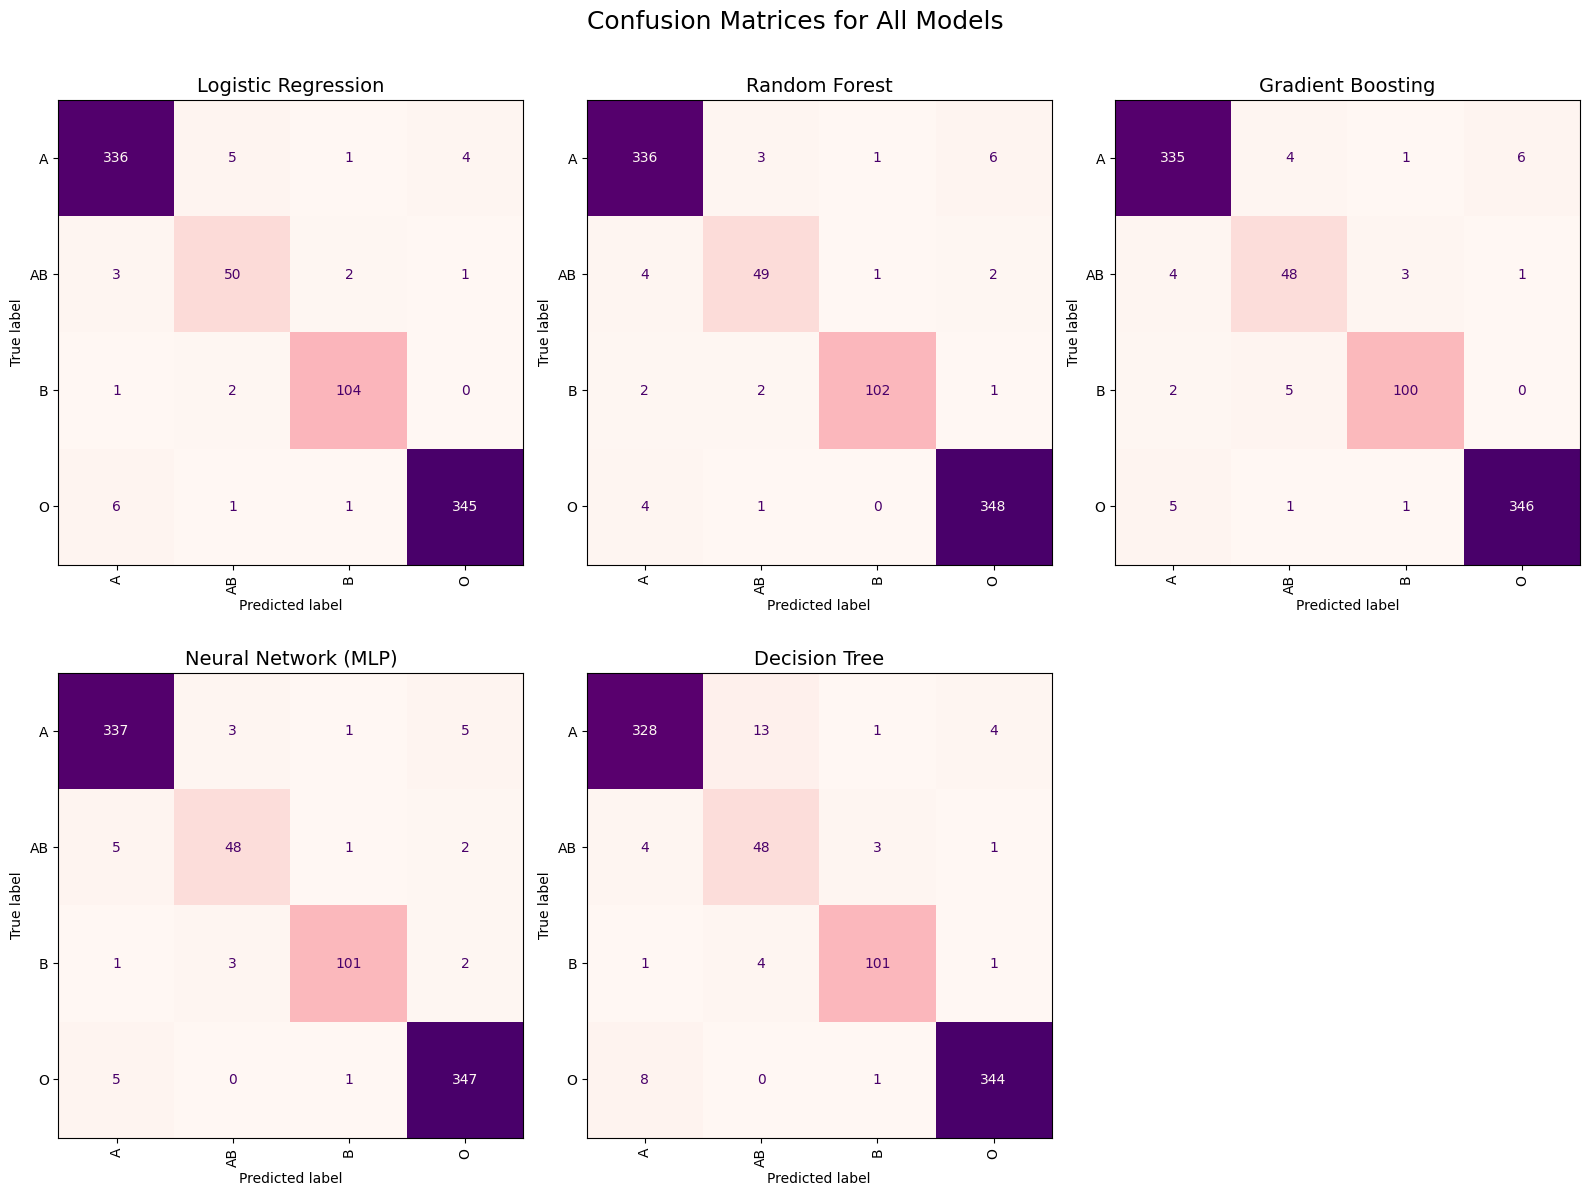


=== Model Comparison Summary ===
               Model  CV Accuracy  CV Weighted F1
 Logistic Regression         0.97            0.97
       Random Forest         0.97            0.97
   Gradient Boosting         0.96            0.96
Neural Network (MLP)         0.97            0.97
       Decision Tree         0.95            0.95
Model summary exported to: results\bloodtype_model_comparison.csv
Classification reports exported to: results\bloodtype_classification_reports.csv


In [10]:
# ===== Train models and evaluate ===== #
# Import trait classifier
from trait_classifier import TraitClassifier

# train models and evaluate
classifier = TraitClassifier(X=bloodtype_encoded[snp_cols],
                             y=bloodtype_encoded['Bloodtype Standardized'],
                             snp_cols=snp_cols,
                             label_name="Bloodtype Standardized",
                             out_prefix="bloodtype")

classifier.evaluate()
classifier.export_results(prefix='bloodtype')

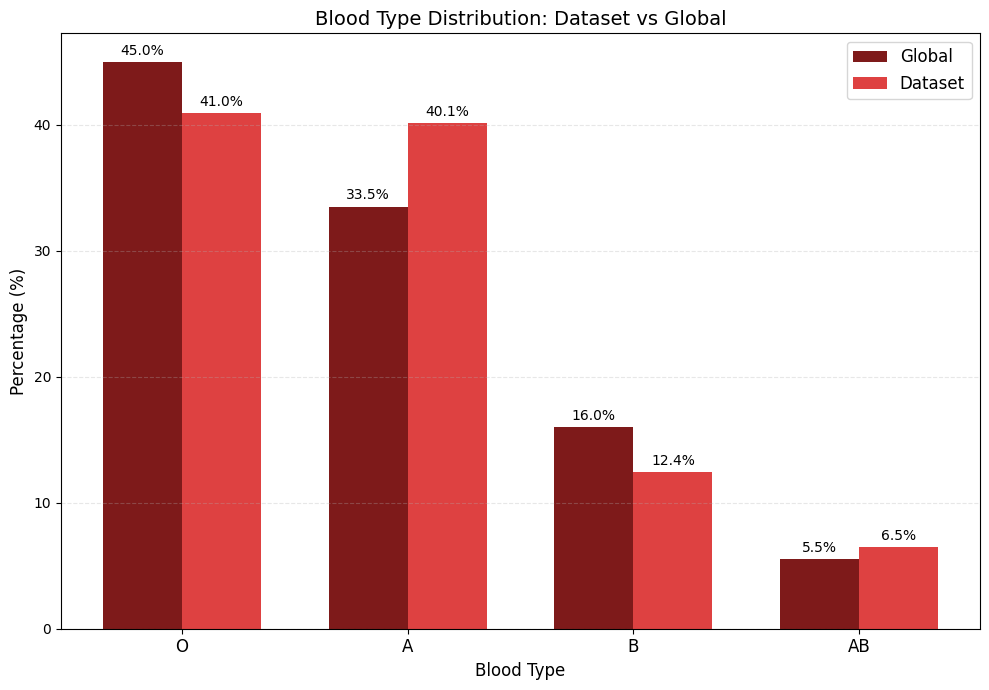

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the visualization
blood_types = ["O", "A", "B", "AB"]
global_distribution = [45, 33.5, 16, 5.5]

# Dataset counts for each blood type (in same order as blood_types)
dataset_counts = [353, 346, 107, 56]
total = sum(dataset_counts)
dataset_distribution = [count / total * 100 for count in dataset_counts]

x = np.arange(len(blood_types))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 7))

bars1 = ax.bar(x - width/2, global_distribution, width, label='Global', color='#700101', alpha=0.9)
bars2 = ax.bar(x + width/2, dataset_distribution, width, label='Dataset', color='#db2c2c', alpha=0.9)

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

# Axis labels, title, and legend
ax.set_xlabel('Blood Type', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Blood Type Distribution: Dataset vs Global', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(blood_types, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()